---
title: "Pandas: Time-series on multiple columns (grouper)"
author: "Damien Martin"
date: "2024-09-10"
categories: [pandas]
---

# Problem

This problem is one that seems simple, but the "missing date" problem can make it really tricky. Let's start with a motivating example. We have some daily data, but some of the days are missing (e.g. we have no sales)

In [1]:
import pandas as pd
import plotnine as p9

sales = pd.DataFrame([
    {'date': '2024-01-01', 'num_sold': 10},
    {'date': '2024-01-02', 'num_sold': 12},
    {'date': '2024-01-03', 'num_sold': 6},
    {'date': '2024-01-04', 'num_sold': 16},
    #{'date': '2024-01-05', 'num_sold': 22},
    {'date': '2024-01-06', 'num_sold': 3},
    #{'date': '2024-01-07', 'num_sold': 8},
    #{'date': '2024-01-08', 'num_sold': 12},
    #{'date': '2024-01-09', 'num_sold': 14},
    {'date': '2024-01-10', 'num_sold': 9},
    {'date': '2024-01-11', 'num_sold': 15},
    {'date': '2024-01-12', 'num_sold': 20},
    {'date': '2024-01-13', 'num_sold': 5},
    #{'date': '2024-01-14', 'num_sold': 7},
    #{'date': '2024-01-15', 'num_sold': 16},
    {'date': '2024-01-16', 'num_sold': 18},
    {'date': '2024-01-17', 'num_sold': 10},
    {'date': '2024-01-18', 'num_sold': 17},
    {'date': '2024-01-19', 'num_sold': 19},
    {'date': '2024-01-20', 'num_sold': 6},
    #{'date': '2024-01-21', 'num_sold': 6},
    #{'date': '2024-01-22', 'num_sold': 18},
    {'date': '2024-01-23', 'num_sold': 22},
    {'date': '2024-01-24', 'num_sold': 12},
    #{'date': '2024-01-25', 'num_sold': 21},
    {'date': '2024-01-26', 'num_sold': 22},
    {'date': '2024-01-27', 'num_sold': 8},
    #{'date': '2024-01-28', 'num_sold': 5},
    {'date': '2024-01-29', 'num_sold': 17},
    {'date': '2024-01-30', 'num_sold': 8},
    {'date': '2024-01-31', 'num_sold': 11},
    {'date': '2024-02-01', 'num_sold': 13},
    {'date': '2024-02-02', 'num_sold': 4},
])
sales['date'] = pd.to_datetime(sales['date'])

We have some sales, with _some_ dates missing (here it is the 5, 7, 8, 9, 14, 15, 21, 22, 25, and 28th of Jan). Maybe the store was closed, or we just didn't have any sales that day. If we calculated a naive moving average, or a weekly sum, it can be challenging. 


In [2]:
sales

,date,num_sold
0,2024-01-01,10
1,2024-01-02,12
2,2024-01-03,6
3,2024-01-04,16
4,2024-01-06,3
5,2024-01-10,9
6,2024-01-11,15
7,2024-01-12,20
8,2024-01-13,5
9,2024-01-16,18


Just doing a lag of 7 would be completely wrong!

There are a couple of ways of doing this. For a single data source, the easiest is to resample on a date index, and then sum:

In [3]:
sales.set_index('date').resample('W')['num_sold'].sum()

date
2024-01-07    47
2024-01-14    49
2024-01-21    70
2024-01-28    64
2024-02-04    53
Freq: W-SUN, Name: num_sold, dtype: int64

We can see even if we eliminate a complete week that the zero still shows

In [4]:
sales[
    (sales['date'] < '2024-01-14') | (sales['date'] > '2024-01-21')
].set_index('date').resample('W')['num_sold'].sum()

date
2024-01-07    47
2024-01-14    49
2024-01-21     0
2024-01-28    64
2024-02-04    53
Freq: W-SUN, Name: num_sold, dtype: int64

## Side note: plots

Some plotting software makes seeing the missing dates easier / harder, so be careful. With a default pandas plot, it can be difficult to notice the missing dates:

<Axes: xlabel='date'>

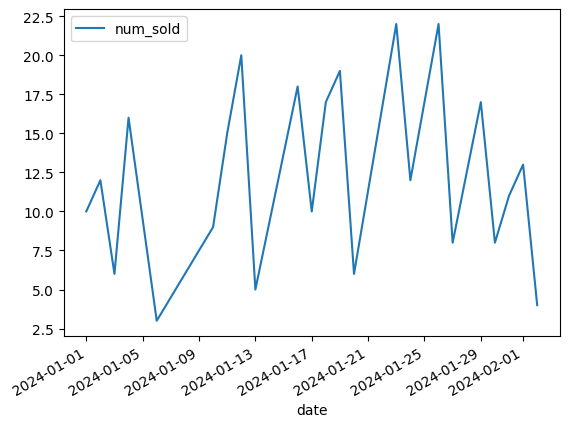

In [5]:
sales.plot(x='date', y='num_sold')

Adding points to the graph (possible in plotnine or using matplotlib) makes it easier to notice.

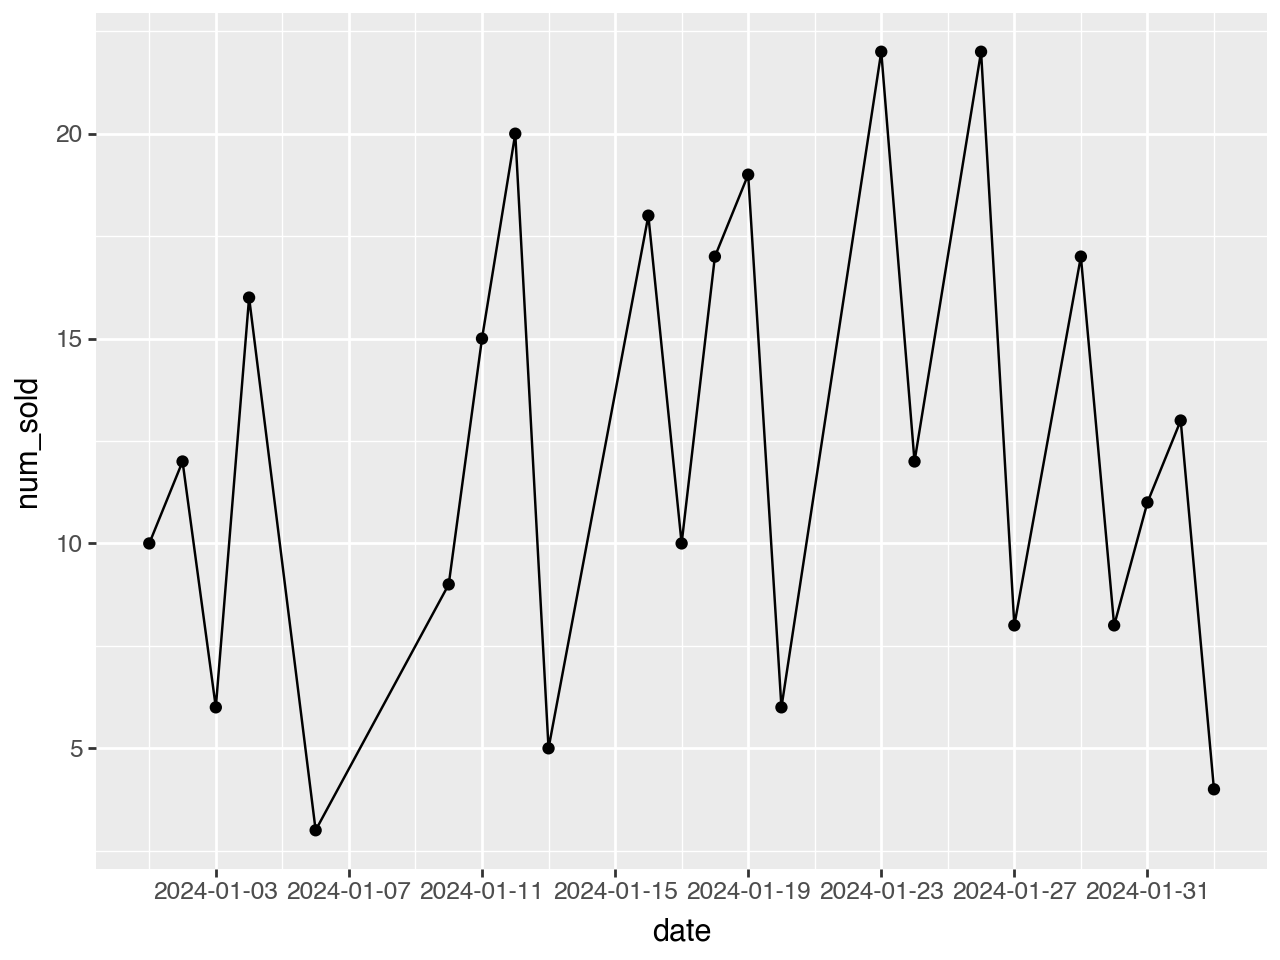

In [6]:
(
    p9.ggplot(sales, p9.aes(x='date', y='num_sold'))
    + p9.geom_line() + p9.geom_point()
    + p9.scale_x_date(breaks='4 day')
)

## Making it harder 

Suppose we had two SKUs we wanted to track: sales of apples and oranges. Then the index trick doesn't work as well. Let's use a much smaller data frame (from [this stackoverflow question](https://stackoverflow.com/questions/45281297/group-by-week-in-pandas))

In [7]:
simple = pd.DataFrame([
    {'fruit': 'apple', 'date': '2017-07-11', 'quantity': 20},
    {'fruit': 'orange', 'date': '2017-07-14', 'quantity': 20},
    {'fruit': 'apple', 'date': '2017-07-14', 'quantity': 70},
    {'fruit': 'orange', 'date': '2017-07-25', 'quantity': 40},
    {'fruit': 'apple', 'date': '2017-07-20', 'quantity': 30},
])
simple['date'] = pd.to_datetime(simple['date'])
simple

,fruit,date,quantity
0,apple,2017-07-11,20
1,orange,2017-07-14,20
2,apple,2017-07-14,70
3,orange,2017-07-25,40
4,apple,2017-07-20,30


You _could_ do a pivot on the fruits, and use a similar resample and sum. This does not scale to having hundreds or thousands of different products.

Instead, you can use a `pandas.Grouper` on the date. This allows us to transform the column, and then group by the transformed output!

In [8]:
(
    simple.groupby(['fruit', pd.Grouper(key='date', freq='W-MON')])['quantity']
    .sum()
    .reset_index()
    .sort_values('date')
)

,fruit,date,quantity
0,apple,2017-07-17,90
2,orange,2017-07-17,20
1,apple,2017-07-24,30
3,orange,2017-07-31,40


## How does this handle missing dates?

In [9]:
simple2 = pd.DataFrame([
    {'fruit': 'apple', 'date': '2017-07-11', 'quantity': 20},
    {'fruit': 'orange', 'date': '2017-07-14', 'quantity': 20},
    {'fruit': 'apple', 'date': '2017-07-14', 'quantity': 70},
    {'fruit': 'orange', 'date': '2017-07-25', 'quantity': 40},
    {'fruit': 'apple', 'date': '2017-07-20', 'quantity': 30},
    {'fruit': 'apple', 'date': '2017-07-30', 'quantity': 30},
    {'fruit': 'apple', 'date': '2017-08-05', 'quantity': 30},
    {'fruit': 'apple', 'date': '2017-08-12', 'quantity': 30},
])
simple2['date'] = pd.to_datetime(simple2['date'])
simple2

,fruit,date,quantity
0,apple,2017-07-11,20
1,orange,2017-07-14,20
2,apple,2017-07-14,70
3,orange,2017-07-25,40
4,apple,2017-07-20,30
5,apple,2017-07-30,30
6,apple,2017-08-05,30
7,apple,2017-08-12,30


In [10]:
(
    simple2.groupby(['fruit', pd.Grouper(key='date', freq='W-MON')])['quantity']
    .sum()
    .reset_index()
    .sort_values('date')
)

,fruit,date,quantity
0,apple,2017-07-17,90
5,orange,2017-07-17,20
1,apple,2017-07-24,30
2,apple,2017-07-31,30
6,orange,2017-07-31,40
3,apple,2017-08-07,30
4,apple,2017-08-14,30
